## Load audio file + processing
First we extract the volume envelope from an audio file (`audio_path`) using a sliding window approach. The envelope is computed as RMS and dB values over time, saved to a JSON file, and key statistics are summarized for further analysis. 

Maybe nice to do this more modulary (load file first etc)

### First downsample, then RMS envelope

In [33]:
def extract_volume_envelope(
    signal_or_path,
    sr=None,
    win_ms=200,
    hop_ms=25,
    to_db=True,
    ref=1.0,
    eps=1e-8,
):
    """
    Compute RMS envelope from audio file or numpy array and return a dict with times, rms, db, and stats.
    If signal_or_path is a string, it is treated as a file path. If it is a numpy array, sr must be provided.
    """
    import numpy as np
    import soundfile as sf
    import os

    if isinstance(signal_or_path, str):
        y, sr_ret = sf.read(signal_or_path, always_2d=False)
        path_for_meta = os.path.abspath(signal_or_path)
    else:
        y = np.asarray(signal_or_path)
        if sr is None:
            raise ValueError("Sample rate (sr) must be provided when passing a numpy array.")
        sr_ret = sr
        path_for_meta = None

    if y.ndim > 1:
        y = np.mean(y, axis=1)
    y = y.astype(np.float32)
    file_mean = float(np.mean(y))
    file_std = float(np.std(y))
    file_peak = float(np.max(np.abs(y)))
    win_samples = max(1, int(round(win_ms * sr_ret / 1000.0)))
    hop_samples = max(1, int(round(hop_ms * sr_ret / 1000.0)))
    pad = win_samples // 2
    y_padded = np.pad(y, pad_width=(pad, pad), mode="constant", constant_values=0.0)
    n_frames = 1 + max(0, (len(y_padded) - win_samples) // hop_samples)
    rms = np.empty(n_frames, dtype=np.float32)
    times_ms = np.empty(n_frames, dtype=np.float32)
    for i in range(n_frames):
        start = i * hop_samples
        frame = y_padded[start : start + win_samples]
        rms[i] = float(np.sqrt(np.mean(frame.astype(np.float64) ** 2)))
        center_sample = start + (win_samples / 2.0) - pad
        times_ms[i] = float((center_sample / float(sr_ret)) * 1000.0)
    level_db = None
    if to_db:
        level_db = 20.0 * np.log10(np.maximum(rms, eps) / float(ref))
        level_db = level_db.astype(np.float32)
    envelope = {
        "times_ms": times_ms.tolist(),
        "rms": rms.tolist(),
        "db": level_db.tolist() if level_db is not None else None,
        "meta": {
            "sr": int(sr_ret),
            "win_ms": int(win_ms),
            "hop_ms": int(hop_ms),
            "to_db": bool(to_db),
            "ref": float(ref),
        },
        "file_stats": {
            "mean": file_mean,
            "std": file_std,
            "peak": file_peak,
            "path": path_for_meta,
        },
    }
    envelope["envelope_stats"] = {
        "rms": {
            "mean": float(np.mean(rms)),
            "std": float(np.std(rms)),
            "peak": float(np.max(rms)),
        },
        "db": {
            "mean": float(np.mean(level_db)) if level_db is not None else None,
            "std": float(np.std(level_db)) if level_db is not None else None,
            "peak": float(np.max(level_db)) if level_db is not None else None,
        },
    }
    return envelope

#### Load and downsample
- Loads the original audio file from `audio_path`
- Converts stereo audio to mono by averaging channels if needed
- Casts the audio to float32
- Downsamples the audio from its original sample rate to 512 Hz using `resample_poly`
- Prints the original and resampled sample rates and sample counts

This prepares the audio for alignment with iEEG data sampled at 512 Hz.

In [ ]:
import soundfile as sf
import numpy as np
from scipy.signal import resample_poly

# Load original audio
audio_path = '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/stimuli/podcast.wav'
target_sr = 512

y, sr_audio = sf.read(audio_path, always_2d=False)
if y.ndim > 1:
    y = y.mean(axis=1)
y = y.astype(np.float32)

# Downsample to target_sr (512 Hz)
gcd = np.gcd(sr_audio, target_sr)
up = target_sr // gcd
down = sr_audio // gcd
downsampled_audio = resample_poly(y, up, down)

print(f"Original SR: {sr_audio}, Resampled SR: {target_sr}, Original samples: {len(y)}, Resampled samples: {len(downsampled_audio)}")

Original SR: 44100, Resampled SR: 512, Original samples: 79380000, Resampled samples: 921600


#### Extract and save audio envelope

- Compute the volume envelope (RMS and dB) from the downsampled audio using a sliding window (`win_ms`, `hop_ms`).
- Save the envelope as a JSON file in `out_dir`.
- The output filename includes the window and hop size for reproducibility.


In [ ]:
import json
import os

# Set input and output paths and parameters
out_dir = '/scratch/gpfs/HASSON/gidon/benchmark-podcast/data/derivatives/audio_features'
win_ms = 200
hop_ms = 25

# Compute envelope
envelope = extract_volume_envelope(downsampled_audio, win_ms=win_ms, hop_ms=hop_ms, sr=target_sr)

# Build output filename with window/hop in name
os.makedirs(out_dir, exist_ok=True)
json_path = os.path.join(out_dir, f'podcast_env_win{win_ms}_hop{hop_ms}.json')

# Save envelope to JSON
with open(json_path, 'w', encoding='utf-8') as fh:
    json.dump(envelope, fh, indent=2)
print(f'Saved envelope JSON to: {json_path}')

Saved envelope JSON to: /scratch/gpfs/HASSON/gp5468/benchmark-podcast/data/derivatives/audio_features/podcast_env_win200_hop25.json


### Inspect envelope JSON and summarize stats
After saving, we load the envelope JSON and print key metadata and envelope-level statistics. This helps verify the extraction and compare across window/hop settings.
- Envelope stats: mean, std, peak for RMS and dB
- File stats: mean, std, peak for raw waveform

In [ ]:
# Load and inspect envelope JSON
import json
json_path = '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/derivatives/audio_features/podcast_env_win200_hop25.json' #for original
json_path_new  = '/scratch/gpfs/HASSON/gidon/benchmark-podcast/data/derivatives/audio_features/podcast_env_win200_hop25_envfirst.json' #for final downsampled
with open(json_path, 'r', encoding='utf-8') as fh:
    env = json.load(fh)
print('Meta:', env['meta']) 
print('Envelope stats:', env.get('envelope_stats', {}))
print('First 10 RMS:', env['rms'][:10])
print(size := len(env['rms']), 'frames total')
with open(json_path_new, 'r', encoding='utf-8') as fh:
    env = json.load(fh)
print('Meta:', env['meta']) 
print('Envelope stats:', env.get('envelope_stats', {}))
print('First 10 RMS:', env['rms'][:10])
print(size := len(env['rms']), 'frames total')

Meta: {'sr': 512, 'win_ms': 200, 'hop_ms': 25, 'to_db': True, 'ref': 1.0}
Envelope stats: {'rms': {'mean': 0.04161183908581734, 'std': 0.02846153825521469, 'peak': 0.22661082446575165}, 'db': {'mean': -31.041385650634766, 'std': 10.110677719116211, 'peak': -12.894387245178223}}
First 10 RMS: [0.014829795807600021, 0.015118158422410488, 0.015279291197657585, 0.015665939077734947, 0.022292111068964005, 0.027186207473278046, 0.05309566482901573, 0.070345938205719, 0.07962952554225922, 0.08834017068147659]
70893 frames total
Meta: {'sr': 512, 'win_ms': 200, 'hop_ms': 25, 'to_db': True, 'ref': 1.0}
Envelope stats: {'rms': {'mean': 0.06932555139064789, 'std': 0.04416896030306816, 'peak': 0.32435843348503113}, 'db': {'mean': -26.406015396118164, 'std': 9.844186782836914, 'peak': -9.779512405395508}}
First 10 RMS: [0.039022672921419144, 0.0420648492872715, 0.045530181378126144, 0.04773474484682083, 0.05238215625286102, 0.05297383666038513, 0.07125584781169891, 0.08699410408735275, 0.0985671505

## Load and process the IEEG data

In [1]:
import numpy as np
import mne

def load_ieeg_data(edf_path):
    """
    Load iEEG data from an EDF file and return a numpy array (electrodes x time), 
    channel names, and sample rate.
    
    Parameters:
        edf_path (str): Path to the EDF file.
        
    Returns:
        data (np.ndarray): Array of shape (n_electrodes, n_timepoints).
        ch_names (list): List of electrode/channel names.
        sfreq (float): Sample frequency (Hz).
    """
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    data = raw.get_data()  # shape: (n_channels, n_timepoints)
    ch_names = raw.ch_names
    sfreq = raw.info['sfreq']
    return data, ch_names, sfreq

### Load and inspect ieeg file(s)

In [2]:
import mne

def load_multiple_ieeg_files(edf_paths):
    """
    Load iEEG data from multiple EDF files.
    Returns:
        data_list: list of np.ndarray (n_electrodes, n_timepoints)
        ch_names_list: list of channel names per file
        sfreq_list: list of sample rates per file
    Checks that all files have the same number of timepoints (second dimension).
    """
    data_list = []
    ch_names_list = []
    sfreq_list = []
    n_timepoints = None
    for path in edf_paths:
        raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
        data = raw.get_data()
        ch_names = raw.ch_names
        sfreq = raw.info['sfreq']
        if n_timepoints is None:
            n_timepoints = data.shape[1]
        # elif data.shape[1] != n_timepoints:
        #     raise ValueError(f"File {path} has {data.shape[1]} timepoints, expected {n_timepoints}.")
        data_list.append(data)
        ch_names_list.append(ch_names)
        sfreq_list.append(sfreq)
    return data_list, ch_names_list, sfreq_list


In [3]:
data_list, ch_names_list, sfreq_list = load_multiple_ieeg_files(['/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-01/ieeg/sub-01_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-02/ieeg/sub-02_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-03/ieeg/sub-03_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-04/ieeg/sub-04_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-05/ieeg/sub-05_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-06/ieeg/sub-06_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-07/ieeg/sub-07_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-08/ieeg/sub-08_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-09/ieeg/sub-09_task-podcast_ieeg.edf'])
print(f'Channel names: {ch_names_list[1]}')
print(f'Sample rate: {sfreq_list[1]}')

ieeg_target_sr = audio_target_sr = sfreq = sfreq_list[1]

for idx in range(len(data_list)):
    print(f'Data shape for subject 0{idx+1}: {data_list[idx].shape}') # (n_electrodes, n_timepoints)

/tmp/ipykernel_278719/1166469410.py:17: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
/tmp/ipykernel_278719/1166469410.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)


KeyboardInterrupt: 

In [ ]:
raw = mne.io.read_raw_edf("data/sub-01/ieeg/sub-01_task-podcast_ieeg.edf", preload=False)
raw._orig_units

### Subject 07 has 4x more datapoints; sampling rate is 2048 instead of 512, so resample


In [4]:
import numpy as np
from scipy.signal import resample_poly

# Subject 07 index and data
subject_07_idx = 6
data_07 = data_list[subject_07_idx]
sr_07 = sfreq_list[subject_07_idx]
target_sr = ieeg_target_sr

# Calculate up/down factors for resample_poly
gcd = int(np.gcd(int(sr_07), int(target_sr)))
up = int(target_sr // gcd)
down = int(sr_07 // gcd)

# Resample each electrode separately
data_07_resampled = np.array([
    resample_poly(channel, up, down)
    for channel in data_07
], dtype=np.float32)

print(f"Subject 07 original shape: {data_07.shape}, resampled shape: {data_07_resampled.shape}")

# Replace in data_list and sfreq_list
data_list[subject_07_idx] = data_07_resampled
sfreq_list[subject_07_idx] = target_sr

Subject 07 original shape: (138, 3686400), resampled shape: (138, 921600)


### Compute the RMS envelopes for the ieeg data of all the subjects

In [5]:
# Define the window and hop sizes for RMS envelope calculation
win_ms = 200 
hop_ms = 25

In [6]:
def compute_selected_ieeg_rms_envelope(
    data,
    electrode_indices=None,
    sfreq=sfreq,
    win_ms=win_ms,
    hop_ms=hop_ms
):
    """
    Compute RMS envelope for selected iEEG electrodes.

    Parameters:
        data (np.ndarray): iEEG data, shape (n_electrodes, n_samples)
        electrode_indices (list or None): Indices of electrodes to use. If None, use all.
        sfreq (float): Sample rate in Hz (default 512).
        win_ms (int): Window size in ms (default 200).
        hop_ms (int): Hop size in ms (default 25).

    Returns:
        dict with keys:
            'rms_matrix': np.ndarray, shape (n_electrodes_selected, n_frames)
            'times_ms': np.ndarray, shape (n_frames,)
            'meta': dict with n_electrodes, win_ms, hop_ms, sfreq
            'rms_stats': list of dicts with mean, std, peak per electrode
    """
    if electrode_indices is None:
        signals = data
    else:
        signals = data[electrode_indices, :]

    n_electrodes = signals.shape[0]
    win_samples = max(1, int(round(win_ms * sfreq / 1000.0)))
    hop_samples = max(1, int(round(hop_ms * sfreq / 1000.0)))
    pad = win_samples // 2
    sig_padded = np.pad(signals, ((0, 0), (pad, pad)), mode='constant', constant_values=0.0)
    n_frames = 1 + max(0, (sig_padded.shape[1] - win_samples) // hop_samples)
    rms_matrix = np.empty((n_electrodes, n_frames), dtype=np.float32)
    times_ms = np.empty(n_frames, dtype=np.float32)
    for i in range(n_frames):
        start = i * hop_samples
        frame = sig_padded[:, start : start + win_samples]
        rms_matrix[:, i] = np.sqrt(np.mean(frame.astype(np.float64) ** 2, axis=1))
        center_sample = start + (win_samples / 2.0) - pad
        times_ms[i] = float((center_sample / float(sfreq)) * 1000.0)
    rms_stats = []
    for j in range(n_electrodes):
        rms_stats.append({
            'mean': float(np.mean(rms_matrix[j])),
            'std': float(np.std(rms_matrix[j])),
            'peak': float(np.max(rms_matrix[j]))
        })
    return {
        'rms_matrix': rms_matrix,
        'times_ms': times_ms,
        'meta': {
            'n_electrodes': n_electrodes,
            'win_ms': win_ms,
            'hop_ms': hop_ms,
            'sfreq': sfreq
        },
        'rms_stats': rms_stats
    }

### Convert electrode name to index

In [ ]:
# import pandas as pd
# import os
# import numpy as np

# def electrode_names_to_indices(subject_id, electrode_names, base_dir='/home/gidon/data'):
#     """
#     Convert electrode names to indices for a given subject using the electrodes.tsv file.

#     Parameters:
#         subject_id (str or int): Subject number, e.g. '01', '05', or 1, 5.
#         electrode_names (list of str): List of electrode names to convert.
#         base_dir (str): Base directory containing subject folders.

#     Returns:
#         indices (list of int): List of indices corresponding to electrode_names.
#     """
#     # Ensure subject_id is zero-padded string
#     subj_str = f"{int(subject_id):02d}"
#     tsv_path = os.path.join(base_dir, f"sub-{subj_str}", "ieeg", f"sub-{subj_str}_space-MNI152NLin2009aSym_electrodes.tsv")
#     df = pd.read_csv(tsv_path, sep='\t')
#     # Map names to indices (row number in file)
#     name_to_idx = {row['name']: idx for idx, row in df.iterrows()}
#     indices = []
#     for name in electrode_names:
#         if name in name_to_idx:
#             indices.append(name_to_idx[name])
#         else:
#             raise ValueError(f"Electrode name '{name}' not found in {tsv_path}")

#     # Return indices as a single row (1D numpy array)
#     return np.array(indices).reshape(1, -1)

In [8]:
# electrode_names_to_indices(9, [
# 'G116',
# 'G117',
# 'G124',
# 'G125',
# 'G128',
# 'G43',
# 'G44',
# 'G45',
# 'G46',
# 'G52',
# 'G53',
# 'G54',
# 'G55',
# 'G56'
# ])

### Select the subjects and electrodes

In [9]:
all_significant_electrodes = [
    [14,16,20,21,22,23,26,27,28,41,49,55,62,73,72], #sub-01	661
    [], #sub-02	662
    [10,18,27,32,36,37,38,39,4,44,46,47,9,108,112,113,114,116,117,119,120,121,122,126,66,71,74,75,78,79,80,82,85,86,87,88,95,158,179,173,174,175,176], #sub-03 717
    [12,34,36,35,15,25,26,56,64,68,69,101,102,103,115,116,155,31,32], #sub-04	723
    [47,63,43,44,46,14,23], #sub-05	741
    [165,159,101,102,103,104,108,110,111,113,117,118,119,120,121,124,125,128,15,22,23,24,30,31,34,35,37,42,43,44,45,53,54,55,56,61,63,64,7,75], #sub-06	742
    [3,11,64,46,47,44,45,52,53,54,19,10], #sub-07	743
    [25,33,49,67,15,31,32,20,21,23,24,34,71,72,75,68], #sub-08	763
    [164,131,190,191,10,12,15,16,17,18,19,20,26,27,5,56,77,79,83,84,86,87,88,92,93,94,95,96,140,142,154], #sub-09 798
]

stg_electrodes = [
    [],
    [],
    [27, 34, 35, 36, 37, 38, 43, 44, 45, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
    [],
    [69, 52, 53, 61, 68, 77, 49, 41, 42, 50, 51, 48, 40],
    [99, 100, 101, 102, 108, 109, 111, 112, 117, 118, 119, 123, 124, 13,  20,  21,  28,  29,  35,  36,  37,  44,   5,  88,  89],
    [54, 45, 53, 41, 42, 43, 49, 50, 51, 52, 40, 48],
    [19, 20, 21, 22],
    [111, 112, 119, 120, 123,  41,  42,  43,  44,  50,  51,  52,  53,  54]
]

indiv_subjects = []
for data in data_list:
    n_electrodes = data.shape[0]
    if n_electrodes > 1:
        indiv_subjects.append(list(range(n_electrodes - 1)))
    else:
        indiv_subjects.append([])

#selected based on visual inspection of raw data (mean, std, peak)
bad_electrodes = [ 
    [33, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122],
    [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
    [254, 255, 256, 257, 258, 259, 260, 261],
    [162, 163, 164, 165, 166, 167, 168, 169, 170, 171],
    [41, 131, 161, 162, 163, 164, 165],
    [128, 137, 159, 174, 175, 176],
    [78, 79, 80, 81, 82, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136],
    [41, 58, 75, 82, 83, 84, 85, 86, 87, 88, 89], 
    [58, 59, 60, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203]
]

all_good_electrodes = []
for subj_idx, electrodes in enumerate(indiv_subjects):
    bad = set(bad_electrodes[subj_idx])
    good = [e for e in electrodes if e not in bad]
    all_good_electrodes.append(good)



In [10]:
electrode_set = all_good_electrodes  # Change to 'stg_electrodes' or 'indiv_subjects' as needed
electrode_set_name = 'all_good_electrodes'  # Change to match your selection, e.g. 'stg_electrodes', 'all_significant_electrodes'

result = []
for subj_idx, subj_indices in enumerate(electrode_set): # Change to all_significant_electrodes or stg_electrodes as needed
    res = compute_selected_ieeg_rms_envelope(
        data_list[subj_idx],
        electrode_indices=subj_indices,
        sfreq=sfreq_list[subj_idx],
        win_ms=200,
        hop_ms=25
    )
    result.append(res)
    print(f"\nSubject {subj_idx}:")
    print("RMS envelope shape:", res['rms_matrix'].shape)
    for electrode_idx, stats in zip(subj_indices, res['rms_stats']):
        print(f"Electrode {electrode_idx} stats: Mean={stats['mean']:.4f}, Std={stats['std']:.4f}, Peak={stats['peak']:.4f}")


Subject 0:
RMS envelope shape: (110, 70893)
Electrode 0 stats: Mean=52.3473, Std=24.0164, Peak=293.9942
Electrode 1 stats: Mean=46.7223, Std=22.4543, Peak=218.8219
Electrode 2 stats: Mean=40.9141, Std=25.9110, Peak=296.2847
Electrode 3 stats: Mean=53.7512, Std=40.8728, Peak=666.8723
Electrode 4 stats: Mean=39.1460, Std=18.4289, Peak=249.1795
Electrode 5 stats: Mean=48.8643, Std=25.1310, Peak=475.6404
Electrode 6 stats: Mean=55.7283, Std=24.9686, Peak=366.8863
Electrode 7 stats: Mean=55.1286, Std=22.1148, Peak=352.3102
Electrode 8 stats: Mean=29.5518, Std=18.7348, Peak=267.1721
Electrode 9 stats: Mean=27.5704, Std=14.4768, Peak=136.6106
Electrode 10 stats: Mean=36.7390, Std=25.5985, Peak=303.1939
Electrode 11 stats: Mean=43.6015, Std=32.4914, Peak=509.3636
Electrode 12 stats: Mean=42.3694, Std=20.4770, Peak=393.0036
Electrode 13 stats: Mean=47.6694, Std=22.4198, Peak=284.1696
Electrode 14 stats: Mean=33.2058, Std=15.0238, Peak=131.5438
Electrode 15 stats: Mean=32.4654, Std=14.2770, Pea

### Investigate audio vs iEEG envelope frame alignment
Let's check the sample counts, window/hop parameters, and how the frame calculation differs for audio and iEEG. We'll print:
- Number of samples in each signal
- Window/hop in samples for each
- Padding applied
- Calculated number of frames
- First and last frame times
- Any leftover samples at the end
- Any leftover samples at the end

## Calculate audio envelope and resample based on #IEEG dataframes

In [11]:
import numpy as np
import soundfile as sf
import os

def extract_volume_envelope(
    signal_or_path,
    sr=None,
    win_ms=200,
    hop_ms=25,
    to_db=True,
    ref=1.0,
    eps=1e-8,
):
    """
    Compute RMS envelope from audio file or numpy array and return a dict with times, rms, db, and stats.
    If signal_or_path is a string, it is treated as a file path. If it is a numpy array, sr must be provided.
    """
    if isinstance(signal_or_path, str):
        y, sr_ret = sf.read(signal_or_path, always_2d=False)
        path_for_meta = os.path.abspath(signal_or_path)
    else:
        y = np.asarray(signal_or_path)
        if sr is None:
            raise ValueError("Sample rate (sr) must be provided when passing a numpy array.")
        sr_ret = sr
        path_for_meta = None

    if y.ndim > 1:
        y = np.mean(y, axis=1)
    y = y.astype(np.float32)
    file_mean = float(np.mean(y))
    file_std = float(np.std(y))
    file_peak = float(np.max(np.abs(y)))
    win_samples = max(1, int(round(win_ms * sr_ret / 1000.0)))
    hop_samples = max(1, int(round(hop_ms * sr_ret / 1000.0)))
    pad = win_samples // 2
    y_padded = np.pad(y, pad_width=(pad, pad), mode="constant", constant_values=0.0)
    n_frames = 1 + max(0, (len(y_padded) - win_samples) // hop_samples)
    rms = np.empty(n_frames, dtype=np.float32)
    times_ms = np.empty(n_frames, dtype=np.float32)
    for i in range(n_frames):
        start = i * hop_samples
        frame = y_padded[start : start + win_samples]
        rms[i] = float(np.sqrt(np.mean(frame.astype(np.float64) ** 2)))
        center_sample = start + (win_samples / 2.0) - pad
        times_ms[i] = float((center_sample / float(sr_ret)) * 1000.0)
    level_db = None
    if to_db:
        level_db = 20.0 * np.log10(np.maximum(rms, eps) / float(ref))
        level_db = level_db.astype(np.float32)
    envelope = {
        "times_ms": times_ms.tolist(),
        "rms": rms.tolist(),
        "db": level_db.tolist() if level_db is not None else None,
        "meta": {
            "sr": int(sr_ret),
            "win_ms": int(win_ms),
            "hop_ms": int(hop_ms),
            "to_db": bool(to_db),
            "ref": float(ref),
        },
        "file_stats": {
            "mean": file_mean,
            "std": float(file_std),
            "peak": float(file_peak),
            "path": path_for_meta,
        },
    }
    envelope["envelope_stats"] = {
        "rms": {
            "mean": float(np.mean(rms)),
            "std": float(np.std(rms)),
            "peak": float(np.max(rms)),
        },
        "db": {
            "mean": float(np.mean(level_db)) if level_db is not None else None,
            "std": float(np.std(level_db)) if level_db is not None else None,
            "peak": float(np.max(level_db)) if level_db is not None else None,
        },
    }
    return envelope

In [ ]:
import soundfile as sf
import numpy as np
from scipy.signal import resample # resample_poly is not needed here

audio_target_sr = ieeg_target_sr 

# --- Dynamically Determine Target Number of Frames for Audio Envelope from iEEG ---
# This assumes 'result' (your list of iEEG envelope dictionaries) is available.
# We use the first subject's iEEG envelope to set the target frame count for audio.
# All iEEG envelopes should have the same frame count if processing is consistent.
try:
    target_n_frames_for_audio_envelope = len(result[0]['rms_matrix'][0])
    print(f"Dynamically determined target frames for audio envelope (from iEEG Subject 01): {target_n_frames_for_audio_envelope}")
except NameError:
    print("ERROR: 'result' variable (iEEG envelopes) not found. Please ensure iEEG processing cells have been run.")
    # Fallback to a hardcoded value for execution, but this indicates a setup issue.
    target_n_frames_for_audio_envelope = 70893 
    print(f"Falling back to hardcoded target frames for audio envelope: {target_n_frames_for_audio_envelope}")
except IndexError:
    print("ERROR: 'result' is empty or malformed. Ensure iEEG envelopes were successfully computed.")
    target_n_frames_for_audio_envelope = 70893 
    print(f"Falling back to hardcoded target frames for audio envelope: {target_n_frames_for_audio_envelope}")


# --- Audio Signal Processing ---
audio_path = '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/stimuli/podcast.wav'
y, sr_audio = sf.read(audio_path, always_2d=False)
if y.ndim > 1:
    y = np.mean(y, axis=1)
y = y.astype(np.float32)
print(f"Original Audio SR: {sr_audio}, Original Audio samples: {len(y)}")

# --- Step 1: Calculate envelope on original high-SR audio ---
envelope_high_res_dict = extract_volume_envelope(y, sr=sr_audio, win_ms=win_ms, hop_ms=hop_ms)
rms_high_res = np.array(envelope_high_res_dict['rms'], dtype=np.float32)
db_high_res = np.array(envelope_high_res_dict['db'], dtype=np.float32) if envelope_high_res_dict['db'] is not None else None
print(f"Number of envelope frames from high-res audio before resampling: {len(rms_high_res)}")

# --- Step 2: Resample the high-resolution audio envelope arrays to the dynamically derived target_n_frames ---
downsampled_rms = resample(rms_high_res, target_n_frames_for_audio_envelope)
downsampled_db = resample(db_high_res, target_n_frames_for_audio_envelope) if db_high_res is not None else None
print(f"Number of frames after downsampling audio envelope: {len(downsampled_rms)}")
assert len(downsampled_rms) == target_n_frames_for_audio_envelope, "Downsampled RMS length mismatch!"
if downsampled_db is not None:
    assert len(downsampled_db) == target_n_frames_for_audio_envelope, "Downsampled DB length mismatch!"

# --- Step 3: Construct the final audio envelope dictionary with the downsampled data ---
# Generate new `times_ms` consistent with the dynamically determined frame count at `audio_target_sr`.
win_samples_for_final_env = max(1, int(round(win_ms * audio_target_sr / 1000.0)))
hop_samples_for_final_env = max(1, int(round(hop_ms * audio_target_sr / 1000.0)))
pad_for_final_env = win_samples_for_final_env // 2

final_times_ms = np.empty(target_n_frames_for_audio_envelope, dtype=np.float32)
for i in range(target_n_frames_for_audio_envelope):
    start_sample_current_frame = i * hop_samples_for_final_env
    center_sample_relative_to_padded_audio = start_sample_current_frame + (win_samples_for_final_env / 2.0)
    center_sample_relative_to_unpadded_audio = center_sample_relative_to_padded_audio - pad_for_final_env
    final_times_ms[i] = float((center_sample_relative_to_unpadded_audio / float(audio_target_sr)) * 1000.0)

final_envelope = {
    "times_ms": final_times_ms.tolist(),
    "rms": downsampled_rms.tolist(),
    "db": downsampled_db.tolist() if downsampled_db is not None else None,
    "meta": {
        "sr": int(audio_target_sr), # This is the effective sample rate for the audio envelope
        "win_ms": int(win_ms),
        "hop_ms": int(hop_ms),
        "to_db": bool(envelope_high_res_dict['meta']['to_db']),
        "ref": float(envelope_high_res_dict['meta']['ref']),
    },
    "file_stats": envelope_high_res_dict['file_stats'],
    "envelope_stats": {
        "rms": {
            "mean": float(np.mean(downsampled_rms)),
            "std": float(np.std(downsampled_rms)),
            "peak": float(np.max(downsampled_rms)),
        },
        "db": {
            "mean": float(np.mean(downsampled_db)) if downsampled_db is not None else None,
            "std": float(np.std(downsampled_db)) if downsampled_db is not None else None,
            "peak": float(np.max(downsampled_db)) if downsampled_db is not None else None,
        },
    },
}
# Assign to 'envelope' as per your original regression code snippet
envelope = final_envelope

print("Audio envelope calculated on high-resolution audio, then downsampled to dynamically matched iEEG frame count.")

# --- Print statements matching user's request (now fully dynamic) ---
audio_samples_original_file = len(y)
n_frames_audio_env = len(envelope['rms'])

# Assuming `ieeg_target_sr` is available from preceding cells.
sfreq_ieeg_for_print = ieeg_target_sr
n_frames_ieeg_for_print = target_n_frames_for_audio_envelope

print(f"\nAudio envelope: sr={audio_target_sr}, win_ms={win_ms}, hop_ms={hop_ms}, n_frames={n_frames_audio_env}")
print(f"iEEG envelope: sr={sfreq_ieeg_for_print}, win_ms={win_ms}, hop_ms={hop_ms}, n_frames={n_frames_ieeg_for_print}")

Dynamically determined target frames for audio envelope (from iEEG Subject 01): 70893
Original Audio SR: 44100, Original Audio samples: 79380000
Original Audio SR: 44100, Original Audio samples: 79380000
Number of envelope frames from high-res audio before resampling: 72033
Number of frames after downsampling audio envelope: 70893
Audio envelope calculated on high-resolution audio, then downsampled to dynamically matched iEEG frame count.

Audio envelope: sr=512.0, win_ms=200, hop_ms=25, n_frames=70893
iEEG envelope: sr=512.0, win_ms=200, hop_ms=25, n_frames=70893
Number of envelope frames from high-res audio before resampling: 72033
Number of frames after downsampling audio envelope: 70893
Audio envelope calculated on high-resolution audio, then downsampled to dynamically matched iEEG frame count.

Audio envelope: sr=512.0, win_ms=200, hop_ms=25, n_frames=70893
iEEG envelope: sr=512.0, win_ms=200, hop_ms=25, n_frames=70893


In [ ]:
import json
import os

# Set output paths and parameters
out_dir = '/scratch/gpfs/HASSON/gidon/benchmark-podcast/data/derivatives/audio_features'
# win_ms and hop_ms are already available from the previous cell's execution context.

# Build output filename with window/hop in name
os.makedirs(out_dir, exist_ok=True)
json_path = os.path.join(out_dir, f'podcast_env_win{win_ms}_hop{hop_ms}_envfirst.json')

# Save the final_envelope to JSON
with open(json_path, 'w', encoding='utf-8') as fh:
    json.dump(envelope, fh, indent=2) # Using the aliased 'envelope' variable
print(f'Saved envelope JSON to: {json_path}')

Saved envelope JSON to: /scratch/gpfs/HASSON/gp5468/benchmark-podcast/data/derivatives/audio_features/podcast_env_win200_hop25_envfirst.json


Make sure that the number of seconds are absolutely matching



## Analysis

### Full analysis


Total system memory: 1510.8 GB
Available memory: 1298.9 GB
Current process memory: 14571.9 MB

=== INDIVIDUAL SUBJECT ANALYSIS ===
Analyzing each subject separately to compare patterns

--- Subject 1 ---
Subject 1 data shape: (70893, 110)
Memory before processing Subject 1: 14571.9 MB
Starting regression analysis with 201 lags, X shape: (70893, 110)
Memory usage at start: 14571.9 MB
Progress: 0/201 lags, Memory: 14571.9 MB
Progress: 20/201 lags, Memory: 14948.9 MB
Progress: 20/201 lags, Memory: 14948.9 MB
Progress: 40/201 lags, Memory: 14949.2 MB
Progress: 40/201 lags, Memory: 14949.2 MB
Progress: 60/201 lags, Memory: 14952.9 MB
Progress: 60/201 lags, Memory: 14952.9 MB
Progress: 80/201 lags, Memory: 14954.3 MB
Progress: 80/201 lags, Memory: 14954.3 MB
Progress: 100/201 lags, Memory: 14952.1 MB
Progress: 100/201 lags, Memory: 14952.1 MB
Progress: 120/201 lags, Memory: 14952.3 MB
Progress: 120/201 lags, Memory: 14952.3 MB
Progress: 140/201 lags, Memory: 14952.3 MB
Progress: 140/201 lags

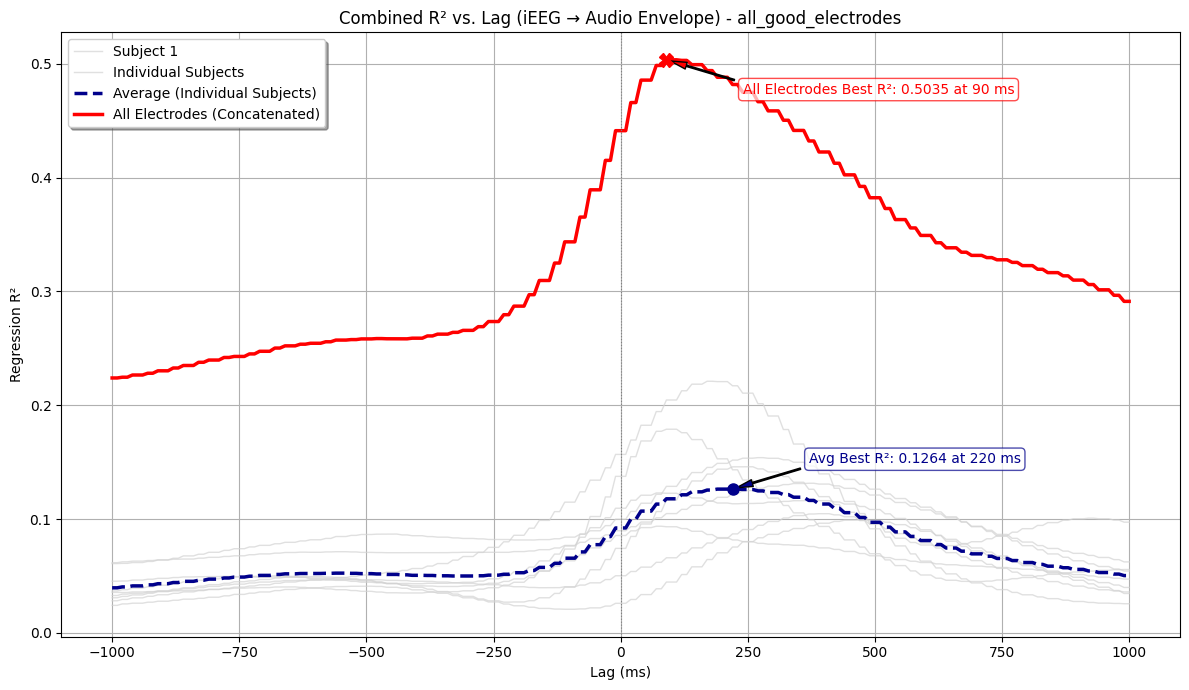

Combined plot saved to: /scratch/gpfs/HASSON/gp5468/podcast-benchmark/plots/Unregularized_reg_all_sub_rms_first_all_good_electrodes.png
Final memory usage: 15301.8 MB


In [ ]:
# This analyzes each subject separately to see individual patterns!

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import gc
import psutil
import sys

max_lag_ms = 1000  # maximum lag to test (+/-)
step_ms = 10     # step size in ms for plot
sr = 512          # sample rate (Hz)
hop_ms = 25       # hop size used for envelope extraction

selected_subjects = [0,1,2,3,4,5,6,7,8]

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def _run_regression_for_lag_helper(X_data, y_data, lags_ms_arr, hop_ms_val, n_splits_kf=10, random_state=42):
    """
    Runs lagged regression analysis for a given X and y dataset.
    Added memory monitoring and garbage collection.
    """
    r2_scores = []
    kf = KFold(n_splits=n_splits_kf, shuffle=True, random_state=random_state)
    
    print(f"Starting regression analysis with {len(lags_ms_arr)} lags, X shape: {X_data.shape}")
    memory_start = get_memory_usage()
    print(f"Memory usage at start: {memory_start:.1f} MB")

    for i, lag_ms in enumerate(lags_ms_arr):
        if i % 20 == 0:  # Print progress every 20 lags
            memory_current = get_memory_usage()
            print(f"Progress: {i}/{len(lags_ms_arr)} lags, Memory: {memory_current:.1f} MB")
            
        lag_frames = int(round(lag_ms / hop_ms_val))
        
        X_shifted, y_shifted = X_data, y_data # Default to no shift

        if lag_frames > 0:
            X_shifted = X_data[lag_frames:]
            y_shifted = y_data[:-lag_frames]
        elif lag_frames < 0:
            X_shifted = X_data[:lag_frames]
            y_shifted = y_data[-lag_frames:]
        
        if len(X_shifted) < n_splits_kf: # Minimum data for KFold
            r2_scores.append(np.nan)
            continue
        
        if X_shifted.ndim == 1: # Ensure X is 2D for StandardScaler
            X_shifted = X_shifted.reshape(-1, 1)

        fold_scores = []
        for train_idx, test_idx in kf.split(X_shifted):
            try:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_shifted[train_idx])
                X_test = scaler.transform(X_shifted[test_idx])

                y_train = y_shifted[train_idx]
                y_test = y_shifted[test_idx]
                
                y_train_std = np.std(y_train)
                if y_train_std == 0: # Avoid division by zero
                    y_train_z = np.zeros_like(y_train)
                    y_test_z = np.zeros_like(y_test)
                else:
                    y_train_z = (y_train - np.mean(y_train)) / y_train_std
                    y_test_z = (y_test - np.mean(y_train)) / y_train_std

                reg = LinearRegression()
                reg.fit(X_train, y_train_z)
                score = reg.score(X_test, y_test_z)
                fold_scores.append(score)
                
                # Clean up intermediate variables
                del X_train, X_test, y_train, y_test, y_train_z, y_test_z, reg, scaler
                
            except Exception as e:
                print(f"Error in fold for lag {lag_ms}ms: {e}")
                fold_scores.append(np.nan)
        
        r2_scores.append(np.mean(fold_scores))
        
        # Clean up
        del X_shifted, y_shifted, fold_scores
        
        # Periodic garbage collection
        if i % 50 == 0:
            gc.collect()
    
    memory_end = get_memory_usage()
    print(f"Regression complete. Final memory: {memory_end:.1f} MB")
    return r2_scores


# Ensure electrode_set_name is defined for plot saving, provide a default if not
if 'electrode_set_name' not in locals():
    electrode_set_name = "all_electrodes" 

# Ensure save_dir is defined, provide a default if not
if 'save_dir' not in locals():
    save_dir = '/scratch/gpfs/HASSON/gidon/podcast-benchmark/plots/'
os.makedirs(save_dir, exist_ok=True)

# --- Setup common variables ---
lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms)
y_audio_env = np.asarray(envelope['rms'])  # Dependent variable for all regressions
n_splits = 10 # Number of folds for KFold CV

print(f"Total system memory: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.1f} MB")

# --- Individual Subject Analysis ---
print("\n=== INDIVIDUAL SUBJECT ANALYSIS ===")
print("Analyzing each subject separately to compare patterns")

all_subjects_r2_curves = [] # To store individual subject R2 curves

try:
    for subject_idx in selected_subjects: # Use subject_idx to avoid conflict with 'subject' in prints
        print(f"\n--- Subject {subject_idx+1} ---")
        
        X = result[subject_idx]['rms_matrix'].T  # shape (n_frames, n_electrodes_this_subject)
        print(f"Subject {subject_idx+1} data shape: {X.shape}")
        
        assert X.shape[0] == y_audio_env.shape[0], \
            f"Frame count mismatch for audio and iEEG for Subject {subject_idx+1}! " \
            f"iEEG: {X.shape[0]}, Audio: {y_audio_env.shape[0]}"

        # Check memory before processing
        memory_before = get_memory_usage()
        print(f"Memory before processing Subject {subject_idx+1}: {memory_before:.1f} MB")
        
        # Run regression for the current subject
        r2_scores = _run_regression_for_lag_helper(X, y_audio_env, lags_ms, hop_ms, n_splits)
        all_subjects_r2_curves.append(r2_scores)
        
        if not np.all(np.isnan(r2_scores)):
            best_r2 = np.nanmax(r2_scores)
            best_lag = lags_ms[np.nanargmax(r2_scores)]
            print(f'Subject {subject_idx+1} - Best R²: {best_r2:.4f} at lag {best_lag} ms')
        else:
            print(f'Subject {subject_idx+1} - No valid R² scores could be computed.')
        
        # Clean up and force garbage collection
        del X, r2_scores
        gc.collect()
        
        memory_after = get_memory_usage()
        print(f"Memory after processing Subject {subject_idx+1}: {memory_after:.1f} MB")

except Exception as e:
    print(f"Error processing subjects: {e}")
    print("Continuing with available data...")

# --- Average Across Subjects Analysis ---
avg_r2_curve = None
if all_subjects_r2_curves:
    all_subjects_r2_curves_arr = np.array(all_subjects_r2_curves, dtype=float)
    if not np.all(np.array([len(c) for c in all_subjects_r2_curves_arr]) == len(lags_ms)):
        print("WARNING: Individual subject R² curves have different lengths or don't match lags_ms. Cannot compute accurate average.")
    else:
        avg_r2_curve = np.nanmean(all_subjects_r2_curves_arr, axis=0)
        print(f"\nAverage R² curve calculated across {len(all_subjects_r2_curves)} subjects.")
        if not np.all(np.isnan(avg_r2_curve)):
            best_r2_avg = np.nanmax(avg_r2_curve)
            best_lag_avg = lags_ms[np.nanargmax(avg_r2_curve)]
            print(f'Average - Best R²: {best_r2_avg:.4f} at lag {best_lag_avg} ms')
        else:
            print('Average - No valid R² scores could be computed.')
else:
    print("No individual subject R² curves to average.")

# --- All Electrodes At Once Analysis ---
r2_scores_all_electrodes = [] # Initialize as empty list
if selected_subjects and all_subjects_r2_curves: # Only run if there are subjects and we have some results
    print(f"\n=== ALL ELECTRODES ANALYSIS ===")
    memory_before_all = get_memory_usage()
    print(f"Memory before all electrodes analysis: {memory_before_all:.1f} MB")
    
    try:
        all_X_matrices = []
        for s_idx in selected_subjects[:len(all_subjects_r2_curves)]:  # Only include successfully processed subjects
            X_current_subject = result[s_idx]['rms_matrix'].T
            if X_current_subject.shape[0] == y_audio_env.shape[0]:
                all_X_matrices.append(X_current_subject)
                print(f"Added Subject {s_idx+1} to combined analysis, shape: {X_current_subject.shape}")
            else:
                print(f"Skipping Subject {s_idx+1} for 'All Electrodes' analysis due to frame mismatch.")

        if all_X_matrices:
            X_all_electrodes = np.concatenate(all_X_matrices, axis=1) # Concatenate along feature dimension
            print(f"Combined X (all electrodes, all subjects) shape: {X_all_electrodes.shape}")
            
            memory_combined = get_memory_usage()
            print(f"Memory after creating combined matrix: {memory_combined:.1f} MB")
            
            r2_scores_all_electrodes = _run_regression_for_lag_helper(X_all_electrodes, y_audio_env, lags_ms, hop_ms, n_splits)

            if not np.all(np.isnan(r2_scores_all_electrodes)):
                best_r2_all = np.nanmax(r2_scores_all_electrodes)
                best_lag_all = lags_ms[np.nanargmax(r2_scores_all_electrodes)]
                print(f'All Electrodes - Best R²: {best_r2_all:.4f} at lag {best_lag_all} ms')
            else:
                print('All Electrodes - No valid R² scores could be computed.')
                
            # Clean up the large combined matrix
            del X_all_electrodes, all_X_matrices
            gc.collect()
        else:
            print("No valid iEEG data found for 'All Electrodes' analysis after filtering for frame count.")
    
    except Exception as e:
        print(f"Error in all electrodes analysis: {e}")
        print("Skipping all electrodes analysis...")
        r2_scores_all_electrodes = []

else:
    print("No subjects selected or iEEG data found in 'result' for 'All Electrodes' analysis.")

# --- Plotting All Results on a Single Plot ---
print("\n=== GENERATING COMBINED PLOT ===")
combined_plot_path = os.path.join(save_dir, f'Unregularized_reg_all_sub_rms_first_{electrode_set_name}.png')

plt.figure(figsize=(12, 7))

# Plot individual subjects
if all_subjects_r2_curves:
    all_subjects_r2_curves_np = np.array(all_subjects_r2_curves, dtype=float)
    # Plot each individual subject curve, only label the first for legend
    for i, r2_curve in enumerate(all_subjects_r2_curves_np):
        subject_num = selected_subjects[i] if i < len(selected_subjects) else i
        label = f'Subject {subject_num+1}' if i == 0 else "_nolegend_"
        plt.plot(lags_ms, r2_curve, color='lightgray', linestyle='-', linewidth=1, alpha=0.7, label=label)
    # Add a separate, single legend entry for "Individual Subjects" (to make it clear what lightgray lines are)
    plt.plot([], [], color='lightgray', linestyle='-', linewidth=1, alpha=0.7, label='Individual Subjects')

# Plot average curve
if avg_r2_curve is not None and not np.all(np.isnan(avg_r2_curve)):
    plt.plot(lags_ms, avg_r2_curve, color='darkblue', linestyle='--', linewidth=2.5, label='Average (Individual Subjects)')
    # Annotate best point for average
    best_r2_avg = np.nanmax(avg_r2_curve)
    best_lag_avg = lags_ms[np.nanargmax(avg_r2_curve)]
    plt.plot(best_lag_avg, best_r2_avg, 'o', color='darkblue', markersize=8, zorder=5) # Mark best point
    plt.annotate(
        f'Avg Best R²: {best_r2_avg:.4f} at {best_lag_avg} ms',
        xy=(best_lag_avg, best_r2_avg),
        xytext=(best_lag_avg + (150 if best_lag_avg < max_lag_ms*0.8 else -150), best_r2_avg + 0.02), # Adjust text position
        textcoords='data',
        fontsize=10,
        color='darkblue',
        ha='left' if best_lag_avg < max_lag_ms*0.8 else 'right',
        va='bottom',
        arrowprops=dict(facecolor='darkblue', shrink=0.05, width=1, headwidth=5),
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='darkblue', alpha=0.7)
    )

# Plot all electrodes at once curve
if r2_scores_all_electrodes and not np.all(np.isnan(r2_scores_all_electrodes)):
    plt.plot(lags_ms, r2_scores_all_electrodes, color='red', linestyle='-', linewidth=2.5, label='All Electrodes (Concatenated)')
    # Annotate best point for all electrodes
    best_r2_all = np.nanmax(r2_scores_all_electrodes)
    best_lag_all = lags_ms[np.nanargmax(r2_scores_all_electrodes)]
    plt.plot(best_lag_all, best_r2_all, 'X', color='red', markersize=10, zorder=5) # Mark best point
    plt.annotate(
        f'All Electrodes Best R²: {best_r2_all:.4f} at {best_lag_all} ms',
        xy=(best_lag_all, best_r2_all),
        xytext=(best_lag_all + (150 if best_lag_all < max_lag_ms*0.8 else -150), best_r2_all - 0.02), # Adjust text position
        textcoords='data',
        fontsize=10,
        color='red',
        ha='left' if best_lag_all < max_lag_ms*0.8 else 'right',
        va='top',
        arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5),
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.7)
    )

plt.xlabel('Lag (ms)')
plt.ylabel('Regression R²')
plt.title(f'Combined R² vs. Lag (iEEG → Audio Envelope) - {electrode_set_name}')
plt.grid(True)
plt.legend(loc='best', frameon=True, shadow=True)
plt.axvline(0, color='gray', linestyle=':', linewidth=0.8) # Add a vertical line at 0 lag
plt.tight_layout()
plt.savefig(combined_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f'Combined plot saved to: {combined_plot_path}')

# Final memory cleanup
gc.collect()
final_memory = get_memory_usage()
print(f"Final memory usage: {final_memory:.1f} MB")

### Linear regression

=== INDIVIDUAL SUBJECT ANALYSIS ===
Analyzing each subject separately to compare patterns

--- Subject 1 ---
Subject 1 data shape: (70893, 110)


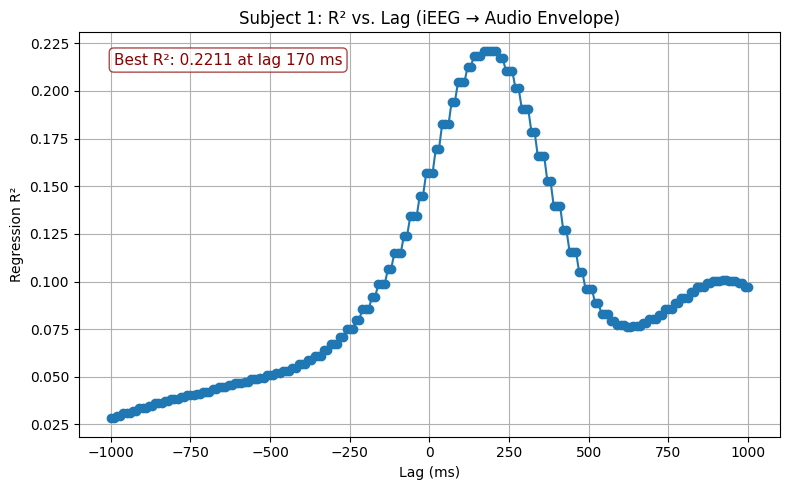

Subject 1 - Best R²: 0.2211 at lag 170 ms
Plot saved to: /scratch/gpfs/HASSON/gp5468/podcast-benchmark/plots/test01/subject_01_lag_analysis_all_good_electrodes.png


In [ ]:
# This analyzes each subject separately to see individual patterns

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Parameters
max_lag_ms = 1000  # maximum lag to test (+/-)
step_ms = 10     # step size in ms for plot
sr = 512          # sample rate (Hz)
hop_ms = 25       # hop size used for envelope extraction

selected_subjects = [0]  # indices of subjects to include

print("=== INDIVIDUAL SUBJECT ANALYSIS ===")
print("Analyzing each subject separately to compare patterns")

for subject in selected_subjects:
    print(f"\n--- Subject {subject+1} ---")
    
    X = result[subject]['rms_matrix'].T  # shape (n_frames, n_electrodes_this_subject)
    print(f"Subject {subject+1} data shape: {X.shape}")
    y = np.asarray(envelope['rms'])  # shape (n_frames,)

    assert X.shape[0] == y.shape[0], "Frame count mismatch!"

    lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms)
    r2_scores = []

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for lag_ms in lags_ms:
        lag_frames = int(round(lag_ms / hop_ms))
        if lag_frames > 0:
            X_shifted = X[lag_frames:]
            y_shifted = y[:-lag_frames]
        elif lag_frames < 0:
            X_shifted = X[:lag_frames]
            y_shifted = y[-lag_frames:]
        else:
            X_shifted = X
            y_shifted = y
        if len(X_shifted) < 10:
            r2_scores.append(np.nan)
            continue

        fold_scores = []
        for train_idx, test_idx in kf.split(X_shifted):
            # Standardize X per fold
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_shifted[train_idx])
            X_test = scaler.transform(X_shifted[test_idx])

            # Z-score y per fold (mean/std from train only)
            y_train = y_shifted[train_idx]
            y_test = y_shifted[test_idx]
            y_train_z = (y_train - np.mean(y_train)) / np.std(y_train)
            y_test_z = (y_test - np.mean(y_train)) / np.std(y_train)

            reg = LinearRegression()
            reg.fit(X_train, y_train_z)
            score = reg.score(X_test, y_test_z)
            fold_scores.append(score)
        r2_scores.append(np.mean(fold_scores))

    # Save the R² vs. lag plot to file
    save_dir = '/scratch/gpfs/HASSON/gidon/podcast-benchmark/plots/test01'
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'subject_{subject+1:02d}_lag_analysis_{electrode_set_name}.png')

    plt.figure(figsize=(8, 5))
    plt.plot(lags_ms, r2_scores, marker='o')
    plt.xlabel('Lag (ms)')
    plt.ylabel('Regression R²')
    plt.title(f'Subject {subject+1}: R² vs. Lag (iEEG → Audio Envelope)')
    plt.grid(True)
    plt.annotate(
        f'Best R²: {max(r2_scores):.4f} at lag {lags_ms[np.nanargmax(r2_scores)]} ms',
        xy=(lags_ms[np.nanargmax(r2_scores)], max(r2_scores)),
        xytext=(0.05, 0.95),
        textcoords='axes fraction',
        fontsize=11,
        color='darkred',
        ha='left',
        va='top',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='darkred', alpha=0.7)
    )
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    best_r2 = max(r2_scores)
    best_lag = lags_ms[np.nanargmax(r2_scores)]
    print(f'Subject {subject+1} - Best R²: {best_r2:.4f} at lag {best_lag} ms')
    print(f'Plot saved to: {plot_path}')

### Ridge regression separate analyses

=== INDIVIDUAL SUBJECT ANALYSIS (Ridge Regression) ===
Analyzing each subject separately to compare patterns.
Ridge alpha set to: 1.0

--- Subject 1 ---
Subject 1 data shape: (70893, 110)
Subject 1 - Best R²: 0.1174 at lag 140 ms


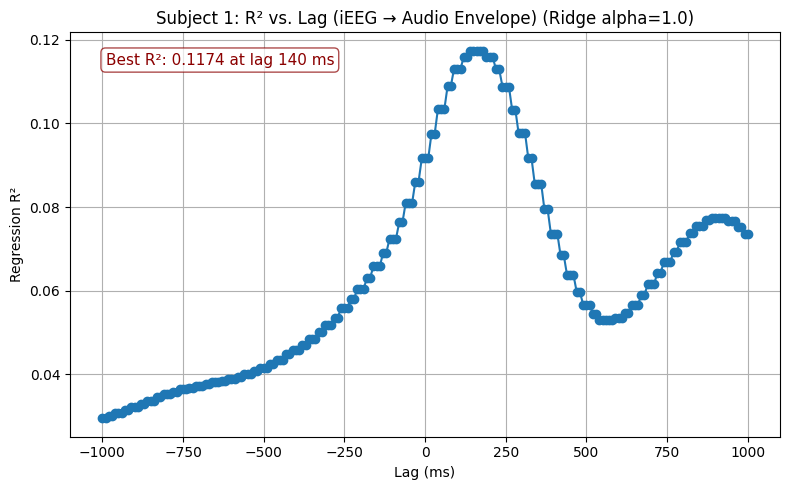

Plot saved to: /home/gp5468/podcast-benchmark/plots/individual_subjects/subject_01_lag_analysis_all_good_electrodes.png

--- Subject 2 ---
Subject 2 data shape: (70893, 100)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge # Added Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# --- Parameters ---
max_lag_ms = 1000  # maximum lag to test (+/-)
step_ms = 10     # step size in ms for plot
sr = 512          # sample rate (Hz)
hop_ms = 25       # hop size used for envelope extraction

selected_subjects = [0,1,2,3,4,5,6,7,8]  # indices of subjects to include

# NEW PARAMETERS FOR RIDGE REGRESSION AND ANALYSIS MODE
ridge_alpha = 1.0 # Alpha parameter for Ridge regression. A higher alpha increases regularization.
analysis_mode = 'individual' # Options: 'individual', 'all_at_once'


# --- Helper function for the core lag analysis loop ---
def perform_lag_analysis(X_data, y_data, plot_title_prefix, filename_prefix, save_dir_base, alpha_ridge):
    """
    Performs lag-based Ridge regression analysis and plots R² scores.

    Args:
        X_data (np.ndarray): The feature matrix (e.g., iEEG RMS), shape (n_frames, n_features).
        y_data (np.ndarray): The target vector (e.g., audio envelope), shape (n_frames,).
        plot_title_prefix (str): Prefix for the plot title (e.g., 'Subject 1', 'All Participants').
        filename_prefix (str): Prefix for the saved plot filename (e.g., 'subject_01', 'all_participants').
        save_dir_base (str): The base directory to save plots.
        alpha_ridge (float): The alpha parameter for Ridge regression.
    """
    lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms)
    r2_scores = []

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for lag_ms in lags_ms:
        lag_frames = int(round(lag_ms / hop_ms))
        if lag_frames > 0:
            X_shifted = X_data[lag_frames:]
            y_shifted = y_data[:-lag_frames]
        elif lag_frames < 0:
            X_shifted = X_data[:lag_frames]
            y_shifted = y_data[-lag_frames:]
        else:
            X_shifted = X_data
            y_shifted = y_data
        
        # Ensure enough data remains after shifting for meaningful regression
        # Using a conservative threshold, e.g., at least n_splits * 2 samples
        if len(X_shifted) < n_splits * 2: 
            r2_scores.append(np.nan)
            continue

        fold_scores = []
        # KFold expects at least 2 samples per split.
        # If len(X_shifted) is small, KFold might fail, so we might need a try-except
        # or a more robust check here if issues arise with very small datasets.
        try:
            for train_idx, test_idx in kf.split(X_shifted):
                # Standardize X per fold
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_shifted[train_idx])
                X_test = scaler.transform(X_shifted[test_idx])

                # Z-score y per fold (mean/std from train only)
                y_train = y_shifted[train_idx]
                y_test = y_shifted[test_idx]
                
                # Handle cases where y_train might have zero std (e.g., all same value)
                y_train_std = np.std(y_train)
                if y_train_std == 0:
                    y_train_z = np.zeros_like(y_train) # Or handle as an error/skip
                    y_test_z = np.zeros_like(y_test)
                else:
                    y_train_z = (y_train - np.mean(y_train)) / y_train_std
                    y_test_z = (y_test - np.mean(y_train)) / y_train_std # IMPORTANT: Use train mean/std for test set

                # Use Ridge regression
                reg = Ridge(alpha=alpha_ridge) 
                reg.fit(X_train, y_train_z)
                score = reg.score(X_test, y_test_z)
                fold_scores.append(score)
            r2_scores.append(np.mean(fold_scores))
        except ValueError as e:
            print(f"Warning: Could not perform KFold split for lag {lag_ms}ms due to data size. Error: {e}")
            r2_scores.append(np.nan)


    # Plotting
    # Ensure the save directory exists
    os.makedirs(save_dir_base, exist_ok=True)
    plot_path = os.path.join(save_dir_base, f'{filename_prefix}_lag_analysis_{electrode_set_name}.png')

    plt.figure(figsize=(8, 5))
    plt.plot(lags_ms, r2_scores, marker='o', linestyle='-')
    plt.xlabel('Lag (ms)')
    plt.ylabel('Regression R²')
    plt.title(f'{plot_title_prefix}: R² vs. Lag (iEEG → Audio Envelope) (Ridge alpha={alpha_ridge})')
    plt.grid(True)
    
    # Annotate best R² if valid scores exist
    if not np.all(np.isnan(r2_scores)):
        best_r2 = np.nanmax(r2_scores)
        best_lag_idx = np.nanargmax(r2_scores)
        best_lag = lags_ms[best_lag_idx]
        
        plt.annotate(
            f'Best R²: {best_r2:.4f} at lag {best_lag} ms',
            xy=(best_lag, best_r2),
            xytext=(0.05, 0.95), # Position text relative to axes
            textcoords='axes fraction',
            fontsize=11,
            color='darkred',
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='darkred', alpha=0.7)
        )
        print(f'{plot_title_prefix} - Best R²: {best_r2:.4f} at lag {best_lag} ms')
    else:
        print(f'{plot_title_prefix} - No valid R² scores found (all NaN for this run).')

    plt.tight_layout()
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f'Plot saved to: {plot_path}')


# --- Main execution logic based on analysis_mode ---

# Extract the common audio envelope once
y_common = np.asarray(envelope['rms']) 

if analysis_mode == 'individual':
    print("=== INDIVIDUAL SUBJECT ANALYSIS (Ridge Regression) ===")
    print("Analyzing each subject separately to compare patterns.")
    print(f"Ridge alpha set to: {ridge_alpha}")

    for subject in selected_subjects:
        print(f"\n--- Subject {subject+1} ---")
        
        # X for the current subject
        X_subject = result[subject]['rms_matrix'].T  # shape (n_frames, n_electrodes_this_subject)
        print(f"Subject {subject+1} data shape: {X_subject.shape}")

        assert X_subject.shape[0] == y_common.shape[0], "Frame count mismatch between iEEG and audio envelope!"

        perform_lag_analysis(
            X_subject, y_common,
            f'Subject {subject+1}',
            f'subject_{subject+1:02d}',
            '/home/gidon/podcast-benchmark/plots/individual_subjects', # Original save directory
            ridge_alpha
        )

elif analysis_mode == 'all_at_once':
    print("\n=== ALL PARTICIPANTS ANALYSIS (Ridge Regression) ===")
    print("Stacking electrodes from all selected subjects to analyze patterns collectively.")
    print(f"Ridge alpha set to: {ridge_alpha}")

    all_subjects_X_list = []
    total_electrodes_count = 0
    # First, collect all subject's X data
    for subject in selected_subjects:
        X_sub = result[subject]['rms_matrix'].T
        # Ensure frame counts match
        assert X_sub.shape[0] == y_common.shape[0], f"Frame count mismatch for subject {subject+1} when combining data!"
        all_subjects_X_list.append(X_sub)
        total_electrodes_count += X_sub.shape[1]

    # Stack all X matrices horizontally to combine electrodes
    X_combined = np.hstack(all_subjects_X_list)
    print(f"Combined data shape (all subjects): {X_combined.shape} (n_frames, total_electrodes={total_electrodes_count})")

    perform_lag_analysis(
        X_combined, y_common,
        f'All Participants (N={len(selected_subjects)})',
        'all_participants',
        '/home/gidon/podcast-benchmark/plots/all_participants', # Separate save directory for combined results
        ridge_alpha
    )

else:
    print(f"Error: Unknown analysis_mode '{analysis_mode}'. Please choose 'individual' or 'all_at_once'.")

over the lags: from all of the patients together, indiv patienst, average. First extract envelope and then downsample (Now we do the opposite

salloc (under 1hr). on an interactive session 

### Ridge regression all


In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# --- Parameters ---
max_lag_ms = 1000  # maximum lag to test (+/-)
step_ms = 10     # step size in ms for plot
sr = 512          # sample rate (Hz)
hop_ms = 25       # hop size used for envelope extraction

selected_subjects = [0,1,2,3,4,5,6,7,8]  # indices of subjects to include

ridge_alpha = 1.0 

# --- Helper function for the core lag analysis loop ---
def perform_lag_analysis(X_data, y_data, analysis_label, alpha_ridge):
    """
    Performs lag-based Ridge regression analysis and returns R² scores.

    Args:
        X_data (np.ndarray): The feature matrix (e.g., iEEG RMS), shape (n_frames, n_features).
        y_data (np.ndarray): The target vector (e.g., audio envelope), shape (n_frames,).
        analysis_label (str): Label for console output (e.g., 'Subject 1', 'All Participants').
        alpha_ridge (float): The alpha parameter for Ridge regression.

    Returns:
        tuple: (lags_ms, r2_scores_list)
    """
    lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms)
    r2_scores = []

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for lag_ms in lags_ms:
        lag_frames = int(round(lag_ms / hop_ms))
        if lag_frames > 0:
            X_shifted = X_data[lag_frames:]
            y_shifted = y_data[:-lag_frames]
        elif lag_frames < 0:
            X_shifted = X_data[:lag_frames]
            y_shifted = y_data[-lag_frames:]
        else:
            X_shifted = X_data
            y_shifted = y_data
        
        # Ensure enough data remains after shifting for meaningful regression
        if len(X_shifted) < n_splits * 2: 
            r2_scores.append(np.nan)
            continue

        fold_scores = []
        try:
            for train_idx, test_idx in kf.split(X_shifted):
                # Standardize X per fold
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_shifted[train_idx])
                X_test = scaler.transform(X_shifted[test_idx])

                # Z-score y per fold (mean/std from train only)
                y_train = y_shifted[train_idx]
                y_test = y_shifted[test_idx]
                
                # Handle cases where y_train might have zero std
                y_train_std = np.std(y_train)
                if y_train_std == 0:
                    y_train_z = np.zeros_like(y_train)
                    y_test_z = np.zeros_like(y_test)
                else:
                    y_train_z = (y_train - np.mean(y_train)) / y_train_std
                    y_test_z = (y_test - np.mean(y_train)) / y_train_std

                # Use Ridge regression
                reg = Ridge(alpha=alpha_ridge) 
                reg.fit(X_train, y_train_z)
                score = reg.score(X_test, y_test_z)
                fold_scores.append(score)
            r2_scores.append(np.mean(fold_scores))
        except ValueError as e:
            print(f"Warning: {analysis_label} - Could not perform KFold split for lag {lag_ms}ms due to data size. Error: {e}")
            r2_scores.append(np.nan)

    # Print best R2 for console feedback
    if not np.all(np.isnan(r2_scores)):
        best_r2 = np.nanmax(r2_scores)
        best_lag_idx = np.nanargmax(r2_scores)
        best_lag = lags_ms[best_lag_idx]
        print(f'{analysis_label} - Best R²: {best_r2:.4f} at lag {best_lag} ms')
    else:
        print(f'{analysis_label} - No valid R² scores found (all NaN for this run).')

    return lags_ms, r2_scores


# --- Main execution logic ---

# Extract the common audio envelope once
y_common = np.asarray(envelope['rms']) 
# Define lags_ms once for consistent array length
lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms) 


# --- 1. Perform Individual Subject Analysis ---
print("=== INDIVIDUAL SUBJECT ANALYSIS (Ridge Regression) ===")
print("Analyzing each subject separately.")
print(f"Ridge alpha set to: {ridge_alpha}")

all_individual_r2_scores = []
subject_labels = []

for i, subject in enumerate(selected_subjects):
    print(f"\n--- Subject {subject+1} ---")
    
    X_subject = result[subject]['rms_matrix'].T 
    print(f"Subject {subject+1} data shape: {X_subject.shape}")

    assert X_subject.shape[0] == y_common.shape[0], "Frame count mismatch between iEEG and audio envelope!"

    current_lags_ms, current_r2_scores = perform_lag_analysis(
        X_subject, y_common,
        f'Subject {subject+1}', # Label for console
        ridge_alpha
    )
    all_individual_r2_scores.append(current_r2_scores)
    subject_labels.append(f'Subject {subject+1}')

all_individual_r2_scores = np.array(all_individual_r2_scores) # Convert list of lists to numpy array

# --- 2. Calculate Average Individual R² ---
# Use nanmean to correctly handle potential NaN values in r2_scores
average_individual_r2 = np.nanmean(all_individual_r2_scores, axis=0)
if not np.all(np.isnan(average_individual_r2)):
    print(f"\nAverage Individual R² - Best: {np.nanmax(average_individual_r2):.4f} at lag {lags_ms[np.nanargmax(average_individual_r2)]} ms")
else:
    print(f"\nAverage Individual R² - No valid scores found.")


# --- 3. Perform "All Participants at Once" Analysis ---
print("\n=== ALL PARTICIPANTS ANALYSIS (Ridge Regression) ===")
print("Stacking electrodes from all selected subjects to analyze patterns collectively.")
print(f"Ridge alpha set to: {ridge_alpha}")

all_subjects_X_list = []
total_electrodes_count = 0
for subject in selected_subjects:
    X_sub = result[subject]['rms_matrix'].T
    assert X_sub.shape[0] == y_common.shape[0], f"Frame count mismatch for subject {subject+1} when combining data!"
    all_subjects_X_list.append(X_sub)
    total_electrodes_count += X_sub.shape[1]

X_combined = np.hstack(all_subjects_X_list)
print(f"Combined data shape (all subjects): {X_combined.shape} (n_frames, total_electrodes={total_electrodes_count})")

combined_lags_ms, combined_r2_scores = perform_lag_analysis(
    X_combined, y_common,
    f'All Participants (N={len(selected_subjects)})', # Label for console
    ridge_alpha
)

# --- 4. Generate the Combined Plot ---
save_dir_combined_plot = '/home/gidon/podcast-benchmark/plots/combined_lag_analysis'
os.makedirs(save_dir_combined_plot, exist_ok=True)
plot_path_combined = os.path.join(save_dir_combined_plot, f'all_subjects_combined_plot_{electrode_set_name}.png')

plt.figure(figsize=(12, 8))

# Plot individual subjects
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_subjects))) # Use a colormap for distinct colors
for i, r2_scores_sub in enumerate(all_individual_r2_scores):
    plt.plot(lags_ms, r2_scores_sub, color=colors[i], linestyle='--', alpha=0.6, label=subject_labels[i])

# Plot average of individual subjects
plt.plot(lags_ms, average_individual_r2, color='black', linewidth=3, linestyle='-', label='Average Individual R²')

# Plot all participants combined
plt.plot(lags_ms, combined_r2_scores, color='red', linewidth=3, linestyle='-', label='All Participants Combined R²')

plt.xlabel('Lag (ms)')
plt.ylabel('Regression R²')
plt.title(f'R² vs. Lag (iEEG → Audio Envelope) - All Subjects + Combined (Ridge alpha={ridge_alpha})')
plt.grid(True)
plt.axvline(0, color='gray', linestyle=':', linewidth=0.8) # Mark zero lag

# Annotate overall bests if valid scores exist
if not np.all(np.isnan(average_individual_r2)):
    avg_best_r2 = np.nanmax(average_individual_r2)
    avg_best_lag = lags_ms[np.nanargmax(average_individual_r2)]
    plt.annotate(
        f'Avg Individual Best R²: {avg_best_r2:.4f} at {avg_best_lag} ms',
        xy=(avg_best_lag, avg_best_r2),
        xytext=(0.02, 0.98), textcoords='axes fraction', fontsize=10, color='black', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.7)
    )

if not np.all(np.isnan(combined_r2_scores)):
    combined_best_r2 = np.nanmax(combined_r2_scores)
    combined_best_lag = lags_ms[np.nanargmax(combined_r2_scores)]
    plt.annotate(
        f'Combined Best R²: {combined_best_r2:.4f} at {combined_best_lag} ms',
        xy=(combined_best_lag, combined_best_r2),
        xytext=(0.02, 0.92), textcoords='axes fraction', fontsize=10, color='red', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.7)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Move legend outside to prevent clutter
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.savefig(plot_path_combined, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f'\nCombined plot saved to: {plot_path_combined}')

=== INDIVIDUAL SUBJECT ANALYSIS (Ridge Regression) ===
Analyzing each subject separately.
Ridge alpha set to: 1.0

--- Subject 1 ---
Subject 1 data shape: (70893, 110)


### Alpha as HP

In [ ]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# --- Parameters ---
max_lag_ms = 1000  # maximum lag to test (+/-)
step_ms = 10     # step size in ms for plot
sr = 512          # sample rate (Hz)
hop_ms = 25       # hop size used for envelope extraction

selected_subjects = [0,1,2,3,4,5,6,7,8]  # indices of subjects to include

# RidgeCV hyperparameter range (alpha values to test)
ridge_alphas = np.logspace(-3, 3, 20)  # Test alpha from 0.001 to 1000
print(f"Testing {len(ridge_alphas)} alpha values: {ridge_alphas}")

# --- Helper function for the core lag analysis loop ---
def perform_lag_analysis_ridgecv(X_data, y_data, analysis_label, alpha_candidates):
    """
    Performs lag-based RidgeCV regression analysis with hyperparameter optimization.

    Args:
        X_data (np.ndarray): The feature matrix (e.g., iEEG RMS), shape (n_frames, n_features).
        y_data (np.ndarray): The target vector (e.g., audio envelope), shape (n_frames,).
        analysis_label (str): Label for console output (e.g., 'Subject 1', 'All Participants').
        alpha_candidates (np.ndarray): Array of alpha values to test in RidgeCV.

    Returns:
        tuple: (lags_ms, r2_scores_list, best_alphas_list)
    """
    lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms)
    r2_scores = []
    best_alphas = []

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for lag_ms in lags_ms:
        lag_frames = int(round(lag_ms / hop_ms))
        if lag_frames > 0:
            X_shifted = X_data[lag_frames:]
            y_shifted = y_data[:-lag_frames]
        elif lag_frames < 0:
            X_shifted = X_data[:lag_frames]
            y_shifted = y_data[-lag_frames:]
        else:
            X_shifted = X_data
            y_shifted = y_data
        
        # Ensure enough data remains after shifting for meaningful regression
        if len(X_shifted) < n_splits * 2: 
            r2_scores.append(np.nan)
            best_alphas.append(np.nan)
            continue

        fold_scores = []
        fold_alphas = []
        try:
            for train_idx, test_idx in kf.split(X_shifted):
                # Standardize X per fold
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_shifted[train_idx])
                X_test = scaler.transform(X_shifted[test_idx])

                # Z-score y per fold (mean/std from train only)
                y_train = y_shifted[train_idx]
                y_test = y_shifted[test_idx]
                
                # Handle cases where y_train might have zero std
                y_train_std = np.std(y_train)
                if y_train_std == 0:
                    y_train_z = np.zeros_like(y_train)
                    y_test_z = np.zeros_like(y_test)
                else:
                    y_train_z = (y_train - np.mean(y_train)) / y_train_std
                    y_test_z = (y_test - np.mean(y_train)) / y_train_std

                # Use RidgeCV with hyperparameter optimization
                reg = RidgeCV(alphas=alpha_candidates, cv=5)  # Inner CV for alpha selection
                reg.fit(X_train, y_train_z)
                score = reg.score(X_test, y_test_z)
                fold_scores.append(score)
                fold_alphas.append(reg.alpha_)  # Store the best alpha for this fold
            
            r2_scores.append(np.mean(fold_scores))
            best_alphas.append(np.mean(fold_alphas))  # Average best alpha across folds
        except ValueError as e:
            print(f"Warning: {analysis_label} - Could not perform KFold split for lag {lag_ms}ms due to data size. Error: {e}")
            r2_scores.append(np.nan)
            best_alphas.append(np.nan)

    # Print best R2 for console feedback
    if not np.all(np.isnan(r2_scores)):
        best_r2 = np.nanmax(r2_scores)
        best_lag_idx = np.nanargmax(r2_scores)
        best_lag = lags_ms[best_lag_idx]
        best_alpha_at_best_lag = best_alphas[best_lag_idx]
        print(f'{analysis_label} - Best R²: {best_r2:.4f} at lag {best_lag} ms (best α: {best_alpha_at_best_lag:.4f})')
    else:
        print(f'{analysis_label} - No valid R² scores found (all NaN for this run).')

    return lags_ms, r2_scores, best_alphas


# --- Main execution logic ---

# Extract the common audio envelope once
y_common = np.asarray(envelope['rms']) 
# Define lags_ms once for consistent array length
lags_ms = np.arange(-max_lag_ms, max_lag_ms + step_ms, step_ms) 


# --- 1. Perform Individual Subject Analysis ---
print("=== INDIVIDUAL SUBJECT ANALYSIS (RidgeCV with Hyperparameter Optimization) ===")
print("Analyzing each subject separately.")
print(f"Testing alpha range: {ridge_alphas.min():.3f} to {ridge_alphas.max():.3f}")

all_individual_r2_scores = []
all_individual_best_alphas = []
subject_labels = []

for i, subject in enumerate(selected_subjects):
    print(f"\n--- Subject {subject+1} ---")
    
    X_subject = result[subject]['rms_matrix'].T 
    print(f"Subject {subject+1} data shape: {X_subject.shape}")

    assert X_subject.shape[0] == y_common.shape[0], "Frame count mismatch between iEEG and audio envelope!"

    current_lags_ms, current_r2_scores, current_best_alphas = perform_lag_analysis_ridgecv(
        X_subject, y_common,
        f'Subject {subject+1}', # Label for console
        ridge_alphas
    )
    all_individual_r2_scores.append(current_r2_scores)
    all_individual_best_alphas.append(current_best_alphas)
    subject_labels.append(f'Subject {subject+1}')

all_individual_r2_scores = np.array(all_individual_r2_scores) # Convert list of lists to numpy array
all_individual_best_alphas = np.array(all_individual_best_alphas)

# --- 2. Calculate Average Individual R² ---
# Use nanmean to correctly handle potential NaN values in r2_scores
average_individual_r2 = np.nanmean(all_individual_r2_scores, axis=0)
average_individual_alphas = np.nanmean(all_individual_best_alphas, axis=0)
if not np.all(np.isnan(average_individual_r2)):
    best_avg_idx = np.nanargmax(average_individual_r2)
    print(f"\nAverage Individual R² - Best: {np.nanmax(average_individual_r2):.4f} at lag {lags_ms[best_avg_idx]} ms (avg α: {average_individual_alphas[best_avg_idx]:.4f})")
else:
    print(f"\nAverage Individual R² - No valid scores found.")


# --- 3. Perform "All Participants at Once" Analysis ---
print("\n=== ALL PARTICIPANTS ANALYSIS (RidgeCV with Hyperparameter Optimization) ===")
print("Stacking electrodes from all selected subjects to analyze patterns collectively.")
print(f"Testing alpha range: {ridge_alphas.min():.3f} to {ridge_alphas.max():.3f}")

all_subjects_X_list = []
total_electrodes_count = 0
for subject in selected_subjects:
    X_sub = result[subject]['rms_matrix'].T
    assert X_sub.shape[0] == y_common.shape[0], f"Frame count mismatch for subject {subject+1} when combining data!"
    all_subjects_X_list.append(X_sub)
    total_electrodes_count += X_sub.shape[1]

X_combined = np.hstack(all_subjects_X_list)
print(f"Combined data shape (all subjects): {X_combined.shape} (n_frames, total_electrodes={total_electrodes_count})")

combined_lags_ms, combined_r2_scores, combined_best_alphas = perform_lag_analysis_ridgecv(
    X_combined, y_common,
    f'All Participants (N={len(selected_subjects)})', # Label for console
    ridge_alphas
)

# --- 4. Generate the Combined Plot ---
save_dir_combined_plot = '/home/gidon/podcast-benchmark/plots/combined_lag_analysis'
os.makedirs(save_dir_combined_plot, exist_ok=True)
plot_path_combined = os.path.join(save_dir_combined_plot, f'all_subjects_combined_plot_ridgecv_{electrode_set_name}.png')

plt.figure(figsize=(14, 10))

# Create subplot layout: main plot + alpha plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), height_ratios=[2, 1])

# === Main R² plot ===
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_subjects))) # Use a colormap for distinct colors
for i, r2_scores_sub in enumerate(all_individual_r2_scores):
    ax1.plot(lags_ms, r2_scores_sub, color=colors[i], linestyle='--', alpha=0.6, label=subject_labels[i])

# Plot average of individual subjects
ax1.plot(lags_ms, average_individual_r2, color='black', linewidth=3, linestyle='-', label='Average Individual R²')

# Plot all participants combined
ax1.plot(lags_ms, combined_r2_scores, color='red', linewidth=3, linestyle='-', label='All Participants Combined R²')

ax1.set_xlabel('Lag (ms)')
ax1.set_ylabel('Regression R²')
ax1.set_title(f'R² vs. Lag (iEEG → Audio Envelope) - RidgeCV with Hyperparameter Optimization')
ax1.grid(True)
ax1.axvline(0, color='gray', linestyle=':', linewidth=0.8) # Mark zero lag

# Annotate overall bests if valid scores exist
if not np.all(np.isnan(average_individual_r2)):
    avg_best_r2 = np.nanmax(average_individual_r2)
    avg_best_lag = lags_ms[np.nanargmax(average_individual_r2)]
    avg_best_alpha = average_individual_alphas[np.nanargmax(average_individual_r2)]
    ax1.annotate(
        f'Avg Individual Best R²: {avg_best_r2:.4f} at {avg_best_lag} ms (α: {avg_best_alpha:.3f})',
        xy=(avg_best_lag, avg_best_r2),
        xytext=(0.02, 0.98), textcoords='axes fraction', fontsize=10, color='black', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.7)
    )

if not np.all(np.isnan(combined_r2_scores)):
    combined_best_lag = lags_ms[np.nanargmax(combined_r2_scores)]
    combined_best_alpha = combined_best_alphas[np.nanargmax(combined_r2_scores)]
    ax1.annotate(
        f'Combined Best R²: {combined_best_r2:.4f} at {combined_best_lag} ms (α: {combined_best_alpha:.3f})',
        xy=(combined_best_lag, combined_best_r2),
        xytext=(0.02, 0.92), textcoords='axes fraction', fontsize=10, color='red', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.7)
    )

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Move legend outside

# === Alpha values plot ===
ax2.plot(lags_ms, average_individual_alphas, color='black', linewidth=2, linestyle='-', label='Average Individual Best α')
ax2.plot(lags_ms, combined_best_alphas, color='red', linewidth=2, linestyle='-', label='Combined Best α')
ax2.set_xlabel('Lag (ms)')
ax2.set_ylabel('Best Alpha (α)')
ax2.set_title('Optimal Alpha vs. Lag')
ax2.grid(True)
ax2.axvline(0, color='gray', linestyle=':', linewidth=0.8)
ax2.set_yscale('log')  # Log scale for alpha values
ax2.legend()

plt.tight_layout()
plt.savefig(plot_path_combined, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f'\nCombined plot saved to: {plot_path_combined}')

Testing 20 alpha values: [1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]
=== INDIVIDUAL SUBJECT ANALYSIS (RidgeCV with Hyperparameter Optimization) ===
Analyzing each subject separately.
Testing alpha range: 0.001 to 1000.000

--- Subject 1 ---
Subject 1 data shape: (70893, 110)


KeyboardInterrupt: 